In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

file_path = "/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0.zip"

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # 전체 파일 개수 확인
    count = len(zip_ref.namelist())
    print(f"총 파일 개수: {count:,}개")

총 파일 개수: 5,126,994개


# ECG 기계 측정값 로드

### 1. 기계 측정값 로드 및 변수 생성

In [19]:
# [10] (수정됨) ECG 기계 측정값 로드 및 파생변수(HR, QTc) 생성
import pandas as pd
import numpy as np
import os

# 1. 경로 설정
extract_path = '/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
machine_csv_path = os.path.join(extract_path, 'machine_measurements.csv')

print("[10] 기계 측정값 로드 및 변수 계산 시작")

# 2. 실제 존재하는 컬럼만 로드
# report 컬럼도 일부 가져와서 텍스트 확인용으로 씁니다.
use_cols = [
    'study_id',
    'rr_interval', 'qrs_onset', 'qrs_end', 't_end', # 계산용 원본 변수
    'report_0', 'report_1' # 텍스트 판독문 (STEMI 키워드 찾기용)
]

try:
    # 데이터 로드
    df_machine = pd.read_csv(machine_csv_path, usecols=use_cols)
    print(f"원본 데이터 로드 성공 (Shape: {df_machine.shape})")

    # 3. 변수 계산 (Feature Engineering)
    # MIMIC의 시간 단위는 보통 ms(밀리초)입니다.

    # (1) Heart Rate (심박수) = 60,000 / RR interval (ms)
    # RR이 0이면 무한대가 되므로 처리 필요
    df_machine['heart_rate'] = np.where(
        df_machine['rr_interval'] > 0,
        60000 / df_machine['rr_interval'],
        np.nan
    )

    # (2) QRS Duration = QRS 끝 - QRS 시작
    df_machine['qrs_duration'] = df_machine['qrs_end'] - df_machine['qrs_onset']

    # (3) QT Interval = T파 끝 - QRS 시작
    # (T_end가 결측치가 많을 수 있으니 주의)
    df_machine['qt_interval'] = df_machine['t_end'] - df_machine['qrs_onset']

    # (4) QTc (Bazett's Formula) = QT / sqrt(RR in seconds)
    # RR을 초 단위로 변환: rr_interval / 1000
    df_machine['qtc'] = df_machine['qt_interval'] / np.sqrt(df_machine['rr_interval'] / 1000)

    # 4. 텍스트 데이터 합치기 (report_0 + report_1)
    # 기계가 뱉은 진단명이 여기에 들어있을 확률 99%
    df_machine['interpretation'] = df_machine['report_0'].fillna('') + ' ' + df_machine['report_1'].fillna('')

    print("\n변수 생성 완료!")
    print(df_machine[['study_id', 'heart_rate', 'qrs_duration', 'qtc', 'interpretation']].head())

    # 이상한 값(음수 등) 제거 (간단한 전처리)
    df_machine = df_machine[df_machine['heart_rate'] > 0]

except Exception as e:
    print(f"오류 발생: {e}")

[10] 기계 측정값 로드 및 변수 계산 시작
원본 데이터 로드 성공 (Shape: (800035, 7))

변수 생성 완료!
   study_id  heart_rate  qrs_duration         qtc  \
0  40689238   91.047041            88  428.683272   
1  44458630   83.102493            84  402.492236   
2  49036311  100.000000            82  402.790268   
3  45090959   91.047041            74  441.001757   
4  48446569   91.047041            86  448.392847   

                                   interpretation  
0  Sinus rhythm Possible right atrial abnormality  
1  Sinus rhythm Possible right atrial abnormality  
2                              Sinus tachycardia   
3                                   Sinus rhythm   
4                                   Sinus rhythm   


### 2. 잠재적 STEMI 의심 환자 찾기 (텍스트 + 수치)

In [21]:
import pandas as pd
import numpy as np
import os

# 1. 환경 설정 및 파일 경로 지정
base_path = '/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
ed_base_path = os.path.join(base_path, 'mimic-iv-ed-2.2')
ecg_record_path = os.path.join(base_path, 'record_list.csv')
machine_csv_path = os.path.join(base_path, 'machine_measurements.csv')

# 제외할 확진자 리스트 파일 (고유 환자 784명 기준)
confirmed_cohort_path = os.path.join(base_path, 'cohort_ver40_reordered.csv')

print("데이터 분석 시작: 784명(고유 환자) 확진자 제외 후 숨겨진 환자 발굴")

try:
    # 2. 기준 코호트(확진자 784명) 로드
    if os.path.exists(confirmed_cohort_path):
        df_confirmed = pd.read_csv(confirmed_cohort_path)
        confirmed_ids = df_confirmed['subject_id'].unique()
        # 실제 로드된 고유 환자 수 출력
        print(f"기준 코호트(확진자) 파일 로드 완료: {len(confirmed_ids)}명 (분석 제외 대상)")
    else:
        raise FileNotFoundError(f"코호트 파일을 찾을 수 없습니다: {confirmed_cohort_path}")

    # 3. ED 체류 중 ECG 데이터 매핑
    if 'relevant_ecg_stays' not in locals():
        print("ED 데이터와 ECG 데이터 매핑 중...")

        # ED 데이터 로드
        df_edstays = pd.read_csv(
            os.path.join(ed_base_path, 'edstays.csv'),
            dtype={'subject_id': int, 'stay_id': int},
            parse_dates=['intime', 'outtime']
        )

        # ECG 메타데이터 로드
        df_ecg_records = pd.read_csv(
            ecg_record_path,
            dtype={'subject_id': int},
            parse_dates=['ecg_time']
        )
        df_ecg_records = df_ecg_records[['subject_id', 'study_id', 'ecg_time']]

        # 병합 및 시간 필터링
        merged_temp = pd.merge(df_edstays, df_ecg_records, on='subject_id', how='inner')
        mask_time = (merged_temp['ecg_time'] >= merged_temp['intime']) & \
                    (merged_temp['ecg_time'] <= merged_temp['outtime'])

        relevant_ecg_stays = merged_temp[mask_time].copy()
        print(f"ED 체류 중 촬영된 ECG 기록 확보: {len(relevant_ecg_stays)}건")

    # 4. 기계 측정값 로드 및 변수 계산
    print("기계 측정값 로드 및 파생변수 생성 중...")

    use_cols = ['study_id', 'rr_interval', 'qrs_onset', 'qrs_end', 't_end', 'report_0', 'report_1']
    df_machine = pd.read_csv(machine_csv_path, usecols=use_cols)

    # 변수 계산
    # Heart Rate calculation
    df_machine['heart_rate'] = np.where(df_machine['rr_interval'] > 0, 60000 / df_machine['rr_interval'], np.nan)

    # Interval calculation
    df_machine['qrs_duration'] = df_machine['qrs_end'] - df_machine['qrs_onset']
    df_machine['qt_interval'] = df_machine['t_end'] - df_machine['qrs_onset']

    # QTc calculation (Bazett's Formula)
    df_machine['qtc'] = df_machine['qt_interval'] / np.sqrt(df_machine['rr_interval'] / 1000)

    # Text interpretation merge
    df_machine['interpretation'] = df_machine['report_0'].fillna('') + ' ' + df_machine['report_1'].fillna('')

    print("기계값 계산 완료")

    # 5. 최종 분석: 숨겨진 환자 발굴
    print("최종 분석: 숨겨진 STEMI 환자 발굴 시작")

    # 전체 ED ECG 환자 풀 생성
    df_suspect_pool = pd.merge(
        relevant_ecg_stays[['subject_id', 'stay_id', 'study_id']],
        df_machine,
        on='study_id',
        how='inner'
    )

    # 784명 확진자 제외 (차집합)
    df_unknown = df_suspect_pool[~df_suspect_pool['subject_id'].isin(confirmed_ids)].copy()
    print(f"전체 ED ECG 환자 중 확진자(784명) 제외 후 분석 대상: {df_unknown['subject_id'].nunique()}명")

    # 텍스트 마이닝 (STEMI 키워드 탐색)
    keywords = ['stemi', 'acute mi', 'st elevation', 'infarction', 'injury']
    pattern = '|'.join(keywords)
    df_unknown['text_stemi_flag'] = df_unknown['interpretation'].str.lower().str.contains(pattern, na=False)

    # 결과 집계
    hidden_stemi_patients = df_unknown[df_unknown['text_stemi_flag']]
    unique_hidden_count = hidden_stemi_patients['subject_id'].nunique()

    print("-" * 50)
    print("[분석 결과: 숨겨진 환자 발굴]")
    print(f"1. 기준 코호트(이미 찾은 환자): {len(confirmed_ids)} 명")
    print(f"2. 새로 발굴한 숨겨진 환자: {unique_hidden_count} 명")
    print("-" * 50)

    # 결과 저장
    if unique_hidden_count > 0:
        save_path = os.path.join(base_path, 'hidden_stemi_candidates.csv')
        hidden_stemi_patients.drop_duplicates(subset=['subject_id']).to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"결과 저장 완료: {save_path}")
        print(hidden_stemi_patients[['subject_id', 'interpretation']].head())

except Exception as e:
    print(f"오류 발생: {e}")

데이터 분석 시작: 784명(고유 환자) 확진자 제외 후 숨겨진 환자 발굴
기준 코호트(확진자) 파일 로드 완료: 784명 (분석 제외 대상)
기계 측정값 로드 및 파생변수 생성 중...
기계값 계산 완료
최종 분석: 숨겨진 STEMI 환자 발굴 시작
전체 ED ECG 환자 중 확진자(784명) 제외 후 분석 대상: 83063명
--------------------------------------------------
[분석 결과: 숨겨진 환자 발굴]
1. 기준 코호트(이미 찾은 환자): 784 명
2. 새로 발굴한 숨겨진 환자: 2153 명
--------------------------------------------------
결과 저장 완료: /content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스/hidden_stemi_candidates.csv
     subject_id                                     interpretation
5      10000764  *** CONSIDER ACUTE ST ELEVATION MI *** Sinus r...
6      10000898  *** CONSIDER ACUTE ST ELEVATION MI *** Sinus r...
292    10013483  Sinus rhythm Borderline ST elevation, anterior...
293    10013483  Sinus rhythm Borderline ST elevation, anterior...
370    10015860  Sinus tachycardia ST elevation suggests acute ...


## 3. cohort_ver40_reordered.csv 와 병합

In [25]:
import pandas as pd
import os
import sqlite3
import numpy as np

# 1. 환경 설정 및 경로
base_path = '/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
ed_base_path = os.path.join(base_path, 'mimic-iv-ed-2.2')
db_path = os.path.join(base_path, 'MIMIC4-hosp-icu.db')

original_cohort_path = os.path.join(base_path, 'cohort_ver40_reordered.csv')
hidden_candidates_path = os.path.join(base_path, 'hidden_stemi_candidates.csv')
save_path = os.path.join(base_path, 'cohort_ver20_expanded_STEMI.csv')

print("코호트 병합 시작")

try:
    # 2. 파일 로드
    if not os.path.exists(original_cohort_path) or not os.path.exists(hidden_candidates_path):
        raise FileNotFoundError("필수 파일이 없습니다.")

    df_old = pd.read_csv(original_cohort_path)
    df_new = pd.read_csv(hidden_candidates_path)

    print(f"1. 기존 코호트: {len(df_old)}명")
    print(f"2. 신규 후보군: {len(df_new)}명")

    # -------------------------------------------------------
    # 3. 부족한 정보 채우기 (Logic 개선)
    # -------------------------------------------------------
    df_new_filled = df_new.copy()

    # (A) 시간 정보 및 hadm_id 확보 (EDStays 이용)
    # hadm_id가 있어야 인종(race)을 가져올 수 있음!
    if 'hadm_id' not in df_new_filled.columns or 'intime' not in df_new_filled.columns:
        print("   + ED 방문 기록(edstays.csv)에서 hadm_id 및 시간 정보 로딩...")
        df_edstays = pd.read_csv(os.path.join(ed_base_path, 'edstays.csv'),
                                 dtype={'subject_id': int, 'stay_id': int, 'hadm_id': 'Int64'}, # Int64로 null 처리 가능하게
                                 parse_dates=['intime', 'outtime'])

        # 신규 환자들의 방문 기록 필터링
        df_ed_target = df_edstays[df_edstays['subject_id'].isin(df_new_filled['subject_id'])].copy()

        # 가장 최근 방문 기록 1건만 선택 (분석 편의상)
        df_ed_target = df_ed_target.sort_values('intime', ascending=False).drop_duplicates('subject_id')

        # 필요한 컬럼 병합
        cols_to_merge = ['subject_id', 'stay_id', 'hadm_id', 'intime', 'outtime']
        # 이미 있는 컬럼 제외하고 병합
        cols_to_merge = [c for c in cols_to_merge if c not in df_new_filled.columns or c == 'subject_id']

        df_new_filled = pd.merge(df_new_filled, df_ed_target[cols_to_merge], on='subject_id', how='left')
        print(f"     -> hadm_id 확보 완료 (결측 수: {df_new_filled['hadm_id'].isnull().sum()})")

    # (B) 성별(Gender) 및 인종(Race) 매핑 (DB 이용)
    conn = sqlite3.connect(db_path)

    # 성별 (Patients 테이블)
    if 'gender' not in df_new_filled.columns:
        print("   + DB에서 성별(gender) 정보 로딩...")
        df_pat = pd.read_sql_query("SELECT subject_id, gender FROM patients", conn)
        df_new_filled = pd.merge(df_new_filled, df_pat, on='subject_id', how='left')

    # 인종 (Admissions 테이블) - 이제 hadm_id가 있으므로 가져올 수 있음!
    if 'race' not in df_new_filled.columns:
        print("   + DB에서 인종(race) 정보 로딩...")
        # hadm_id 리스트만 추려서 쿼리하면 좋지만, 간단히 전체 admissions 로드 후 병합
        # (메모리 효율을 위해 필요한 컬럼만 조회)
        df_adm = pd.read_sql_query("SELECT hadm_id, race FROM admissions", conn)

        # 병합 (hadm_id 기준)
        df_new_filled = pd.merge(df_new_filled, df_adm, on='hadm_id', how='left')

        # 만약 hadm_id가 없어서 race가 여전히 NaN인 경우 -> 'UNKNOWN' 등으로 채울 수도 있음
        # df_new_filled['race'] = df_new_filled['race'].fillna('UNKNOWN')

    conn.close()

    # -------------------------------------------------------
    # 4. 컬럼 표준화 및 최종 병합
    # -------------------------------------------------------
    print("컬럼 구조 통일 중...")

    df_old['cohort_source'] = 'ICD_Confirmed'
    df_new_filled['cohort_source'] = 'ECG_Text_Mining'

    # 기존 코호트의 컬럼 순서 기준
    target_cols = list(df_old.columns)

    # 신규 데이터에 없는 컬럼 NaN 처리
    for col in target_cols:
        if col not in df_new_filled.columns:
            df_new_filled[col] = np.nan

    # 신규 분석 컬럼(interpretation, heart_rate 등) 추가
    extra_cols = [c for c in df_new_filled.columns if c not in target_cols]
    final_cols = target_cols + extra_cols

    for col in extra_cols:
        df_old[col] = np.nan

    # 정렬 및 병합
    final_cohort = pd.concat([
        df_old[final_cols],
        df_new_filled[final_cols]
    ], ignore_index=True)

    # -------------------------------------------------------
    # 5. 결과 확인 (전체 컬럼 결측치 확인)
    # -------------------------------------------------------
    print("-" * 30)
    print("최종 병합 완료")
    print(f"1. 기존 코호트: {len(df_old)}")
    print(f"2. 신규 코호트: {len(df_new_filled)}")
    print(f"3. 합계: {len(final_cohort)}")
    print("-" * 30)

    # 모든 컬럼의 결측치 확인
    print("주요 컬럼 결측치(Null) 현황:")
    print(final_cohort[['subject_id', 'gender', 'race']].isnull().sum())
    # 결측치가 있는 컬럼만 출력 (너무 많으면 보기 힘드므로)
    print(null_counts[null_counts > 0])

    final_cohort.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"\n저장 완료: {save_path}")

    # 샘플 데이터 확인 (race가 잘 들어갔는지)
    print("\n[데이터 샘플 (신규 환자)]")
    print(final_cohort[final_cohort['cohort_source']=='ECG_Text_Mining'][['subject_id', 'hadm_id', 'gender', 'race']].head())

except Exception as e:
    print(f"오류 발생: {e}")

코호트 병합 시작
1. 기존 코호트: 836명
2. 신규 후보군: 2153명
   + ED 방문 기록(edstays.csv)에서 hadm_id 및 시간 정보 로딩...
     -> hadm_id 확보 완료 (결측 수: 918)
   + DB에서 성별(gender) 정보 로딩...
   + DB에서 인종(race) 정보 로딩...
컬럼 구조 통일 중...
------------------------------
최종 병합 완료
1. 기존 코호트: 836
2. 신규 코호트: 2153
3. 합계: 2989
------------------------------
주요 컬럼 결측치(Null) 현황:
subject_id      0
gender          0
race          918
dtype: int64
hadm_id                        918
race                           918
arrival_transport             2153
disposition                   2153
first_ecg_time                2524
door_to_ecg_min               2524
admittime                     2153
lab_tat_min                   2555
door_to_antithrombotic_min    2687
door_to_cath_min              2712
boarding_delay_min            2524
death_flag                    2153
los_days                      2227
transfer_type                 2524
is_emergency_admission        2524
dod                           2692
eventtype                     2153
stud

# hidden_stemi_candidates EDA

폰트 설치 (skip 가능)

In [27]:
# [1] 폰트 설치 및 캐시 삭제
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("폰트 설치가 완료되었습니다.")
print("[런타임] -> [세션 다시 시작]을 클릭한 뒤, 맨 첫 번째 셀과 아래 코드를 실행하세요")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

한글 폰트 설치 완료
Hidden STEMI Cohort EDA 시작
데이터 로드 완료: 2153명

[1] 기초 통계 요약 (Describe)


,heart_rate,qtc,qrs_duration,rr_interval
count,2153.00,2153.00,2153.00,2153.00
mean,82.57,431.21,97.18,786.47
std,24.98,34.92,19.70,217.05
min,25.00,275.20,28.00,273.00
25%,65.01,407.25,86.00,638.00
50%,77.02,428.00,93.00,779.00
75%,94.04,451.04,103.00,923.00
max,219.78,646.97,182.00,2400.00



[2] 결측치 확인
subject_id         0
stay_id            0
study_id           0
report_0           0
report_1           0
rr_interval        0
qrs_onset          0
qrs_end            0
t_end              0
heart_rate         0
qrs_duration       0
qt_interval        0
qtc                0
interpretation     0
text_stemi_flag    0
dtype: int64


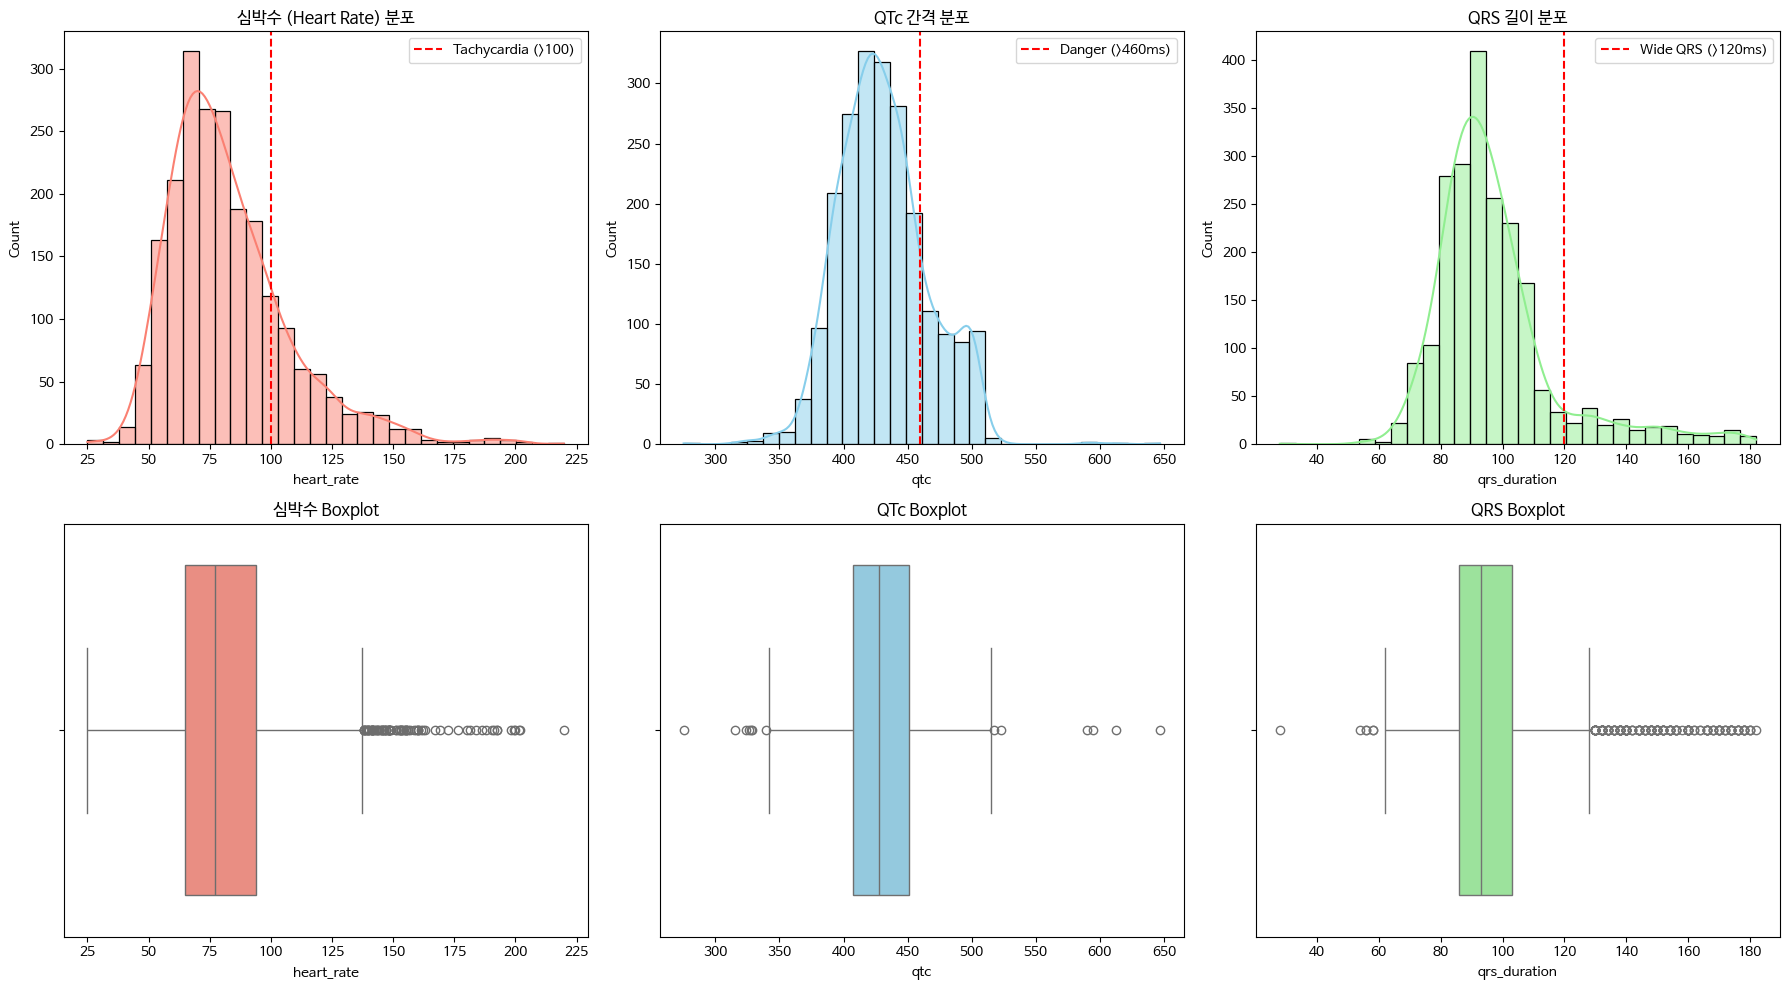


[3] ECG 판독문(Interpretation) 주요 키워드 분석


/tmp/ipython-input-2702527113.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts_y), y=list(words_x), palette='viridis')


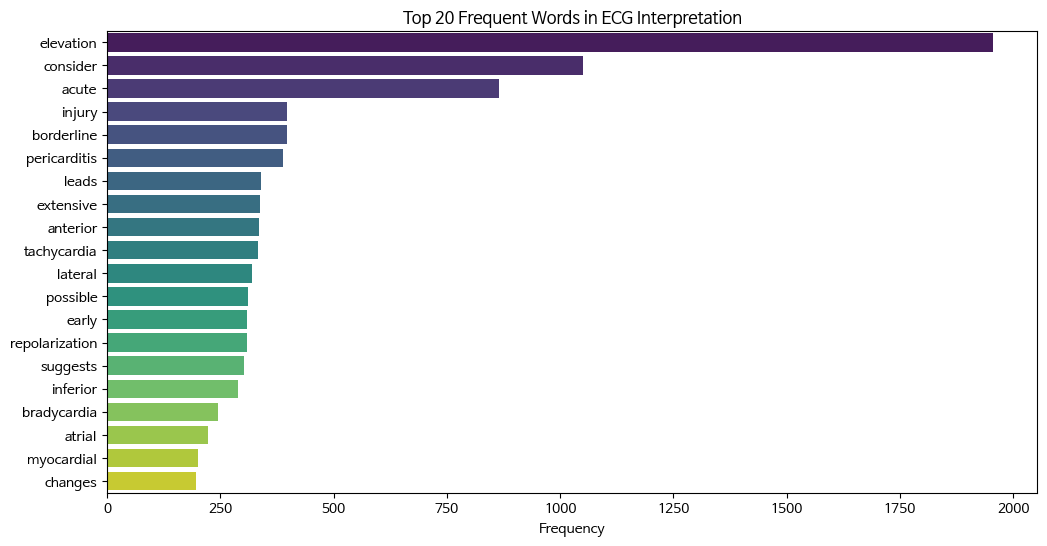


🔎 [EDA 결론: 숨겨진 환자들의 위험도]
분석 대상: 2153명
1. QTc 연장(>460ms, 돌연사 위험): 403명 (18.7%)
2. 빈맥(>100bpm, 위급 상황): 403명 (18.7%)
💡 해석: 이 환자들은 ICD 코드는 없었지만, 기계값이나 판독문 상으로는
상당히 위험한 상태였음을 데이터를 통해 확인할 수 있습니다.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import re

# 1. 파일 경로 설정
base_path = '/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
hidden_candidates_path = os.path.join(base_path, 'hidden_stemi_candidates.csv')

# 한글 폰트 설정 (Colab용)
try:
    import matplotlib.font_manager as fm
    !apt-get -qq -y install fonts-nanum > /dev/null
    fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    font = fm.FontProperties(fname=fontpath, size=9)
    plt.rc('font', family='NanumBarunGothic')
    print("한글 폰트 설치 완료")
except:
    print("한글 폰트 설치 패스 (로컬 환경인 경우 무시)")

print("Hidden STEMI Cohort EDA 시작")

try:
    # 2. 데이터 로드
    if os.path.exists(hidden_candidates_path):
        df_hidden = pd.read_csv(hidden_candidates_path)
        print(f"데이터 로드 완료: {len(df_hidden)}명")
    else:
        raise FileNotFoundError("파일이 없습니다. 이전 단계 코드를 실행해주세요.")

    # 3. 기초 통계 확인
    print("\n[1] 기초 통계 요약 (Describe)")
    display(df_hidden[['heart_rate', 'qtc', 'qrs_duration', 'rr_interval']].describe().round(2))

    print("\n[2] 결측치 확인")
    print(df_hidden.isnull().sum())

    # 4. 수치형 변수 시각화 (분포 확인)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # (1) 심박수 (Heart Rate)
    sns.histplot(df_hidden['heart_rate'], bins=30, kde=True, ax=axes[0, 0], color='salmon')
    axes[0, 0].axvline(100, color='red', linestyle='--', label='Tachycardia (>100)')
    axes[0, 0].set_title('심박수 (Heart Rate) 분포')
    axes[0, 0].legend()

    sns.boxplot(x=df_hidden['heart_rate'], ax=axes[1, 0], color='salmon')
    axes[1, 0].set_title('심박수 Boxplot')

    # (2) QTc Interval
    sns.histplot(df_hidden['qtc'], bins=30, kde=True, ax=axes[0, 1], color='skyblue')
    axes[0, 1].axvline(460, color='red', linestyle='--', label='Danger (>460ms)')
    axes[0, 1].set_title('QTc 간격 분포')
    axes[0, 1].legend()

    sns.boxplot(x=df_hidden['qtc'], ax=axes[1, 1], color='skyblue')
    axes[1, 1].set_title('QTc Boxplot')

    # (3) QRS Duration
    sns.histplot(df_hidden['qrs_duration'], bins=30, kde=True, ax=axes[0, 2], color='lightgreen')
    axes[0, 2].axvline(120, color='red', linestyle='--', label='Wide QRS (>120ms)')
    axes[0, 2].set_title('QRS 길이 분포')
    axes[0, 2].legend()

    sns.boxplot(x=df_hidden['qrs_duration'], ax=axes[1, 2], color='lightgreen')
    axes[1, 2].set_title('QRS Boxplot')

    plt.tight_layout()
    plt.show()

    # 5. 텍스트 마이닝 (빈도 분석)
    print("\n[3] ECG 판독문(Interpretation) 주요 키워드 분석")

    # 텍스트 합치기
    all_text = ' '.join(df_hidden['interpretation'].dropna().astype(str).tolist()).lower()

    # 불용어 제거 및 단어 추출 (간단 버전)
    words = re.findall(r'\b[a-z]{3,}\b', all_text)
    stopwords = ['the', 'and', 'is', 'of', 'to', 'in', 'with', 'for', 'sinus', 'rhythm', 'normal', 'ecg', 'tracing']
    filtered_words = [w for w in words if w not in stopwords]

    # 빈도 계산
    word_counts = Counter(filtered_words).most_common(20)

    # 시각화
    plt.figure(figsize=(12, 6))
    words_x, counts_y = zip(*word_counts)
    sns.barplot(x=list(counts_y), y=list(words_x), palette='viridis')
    plt.title('Top 20 Frequent Words in ECG Interpretation')
    plt.xlabel('Frequency')
    plt.show()

    # 6. 결과 해석 (위험군 비율)
    n_total = len(df_hidden)
    n_risk_qtc = len(df_hidden[df_hidden['qtc'] > 460])
    n_risk_hr = len(df_hidden[df_hidden['heart_rate'] > 100])

    print("\n" + "="*40)
    print("🔎 [EDA 결론: 숨겨진 환자들의 위험도]")
    print(f"분석 대상: {n_total}명")
    print(f"1. QTc 연장(>460ms, 돌연사 위험): {n_risk_qtc}명 ({n_risk_qtc/n_total*100:.1f}%)")
    print(f"2. 빈맥(>100bpm, 위급 상황): {n_risk_hr}명 ({n_risk_hr/n_total*100:.1f}%)")
    print("="*40)
    print("💡 해석: 이 환자들은 ICD 코드는 없었지만, 기계값이나 판독문 상으로는")
    print("상당히 위험한 상태였음을 데이터를 통해 확인할 수 있습니다.")

except Exception as e:
    print(f"오류 발생: {e}")